# _Trial 26_

__July 10, 2019__

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [4]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [5]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [6]:
from test_folder import sample

In [7]:
train_df, valid_df = sample.prep_data(path);

Read in training and validation data sets
------------------------------
Added column to both data sets that indicates if observation is part of validation set or not.
------------------------------
Extracted patient ID and study number for each observation and assigned into new columns.
------------------------------
Filled in NaNs within pathology columns with 0 (see Stanford ML Github for further information on dealing with NaNs).
------------------------------
Converted pathology columns to integer type.
------------------------------
Pre-replacement Label Distribution: Label 0 = 188327, Label 1 = 27000, Label -1 = 8087
------------------------------
Replaced uncertain labels in Cardiomegaly column with 0 (i.e. negative)
Post-replacement Label Distribution: Label 0 = 196414, Label 1 = 27000
Does number of post-replacement 0 labels equal the sum of pre-replacement -1s and 0s? True
Returned training and validation data sets as pandas dataframes.


In [8]:
# set seed to help with reproducibility
sample.set_seed(1)

In [9]:
full_df = sample.undersample_and_prep(train_df, valid_df);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random under-sampling: 
1    27000
0    27000
Name: Cardiomegaly, dtype: int64
------------------------------
Reshuffled rows in new undersampled dataframe.
------------------------------
Concatenated undersampled training data set with validation data.
Returning full data set.


# _Deep Learning Fast.ai Set Up_

In [10]:
from test_folder import replicate

src = replicate.get_src(full_df, path, feature_col='Cardiomegaly')

In [11]:
# use image size of 128 to continue training model from Trial 25
data = replicate.get_data(128, src)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


In [12]:
data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Create DenseNet Model_

# _First Round of Training_

In [13]:
learn = cnn_learner(data=data, base_arch=models.densenet161, metrics=[AUROC(), Precision(), Recall()],
                    pretrained=True, ps=0.5, bn_final=True)

In [ ]:
# load weights from best performing model so far
# learn.load('trial25-densenet-rd2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.26E-06
Min loss divided by 10: 3.98E-03


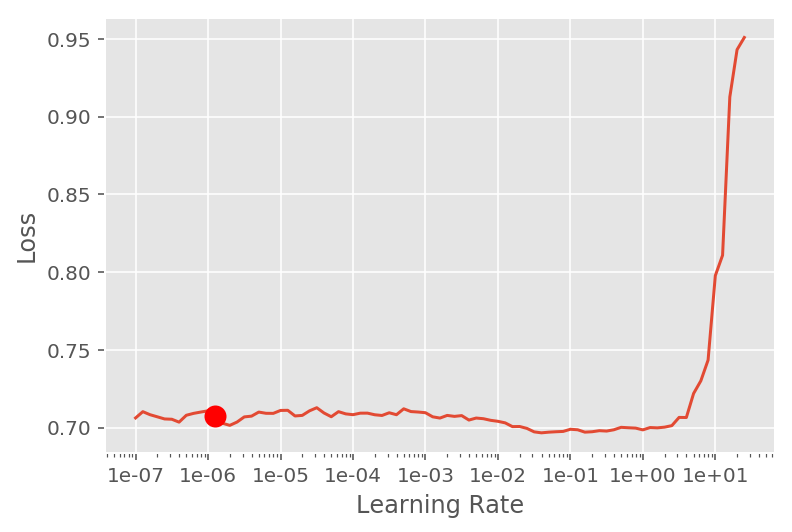

In [13]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

In [14]:
learn.fit_one_cycle(5, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet161_trial26')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.528412,0.526290,0.746013,0.606061,0.294118,11:13
1,0.504270,0.476402,0.803597,0.622222,0.411765,11:11
2,0.499829,0.456952,0.819011,0.649123,0.544118,11:13
3,0.477985,0.457883,0.813519,0.688889,0.455882,11:15
4,0.445530,0.481785,0.783930,0.692308,0.397059,11:15


Better model found at epoch 0 with auroc value: 0.7460134625434875.
Better model found at epoch 1 with auroc value: 0.8035967350006104.
Better model found at epoch 2 with auroc value: 0.8190113306045532.


# _Second Round of Training w/ Image Size of 256_

In [17]:
# use image size of 128 to continue training model from Trial 25
data_256 = replicate.get_data(256, src)

using bs=16, have 7022MB of GPU RAM free.
------------------------------
Data ready.


In [18]:
data_256

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,1,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [19]:
# assign new data with size = 256 to learner
learn.data = data_256

In [20]:
# confirm
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,1,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [21]:
# load best performing weights 
learn.load('best_densenet161_trial26');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-06
Min loss divided by 10: 6.31E-04


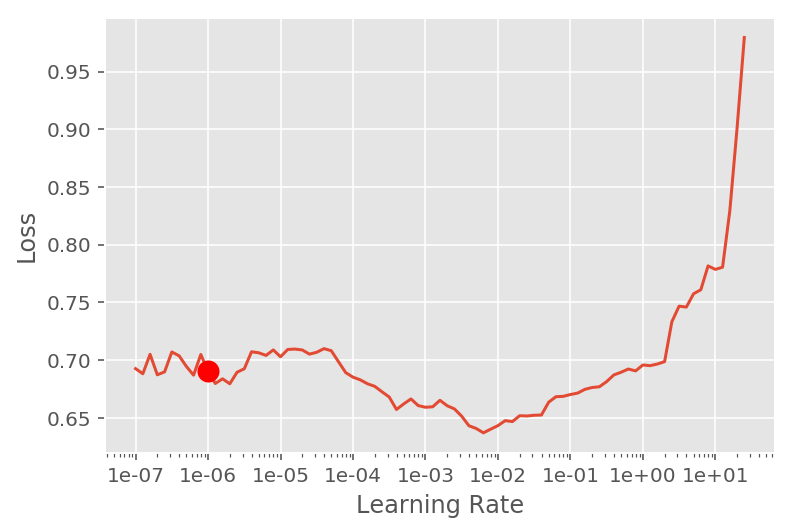

In [22]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

In [23]:
learn.fit_one_cycle(3, 1e-04, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet161_trial26-rd2')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.493589,0.476004,0.800319,0.636364,0.411765,26:03
1,0.480956,0.472143,0.790131,0.717949,0.411765,26:03
2,0.470135,0.470959,0.794295,0.723404,0.500000,26:04


Better model found at epoch 0 with auroc value: 0.8003189563751221.


In [24]:
learn.save('trial26-dn161-rd2')

# _Third Round of Training w/ image size = 320_

In [14]:
# use image size of 320 to continue training model 
data_320 = replicate.get_data(320, src)

using bs=16, have 7022MB of GPU RAM free.
------------------------------
Data ready.


In [15]:
data_320

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,1,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [16]:
learn.data = data_320

In [17]:
learn.load('trial26-dn161-rd2');

In [18]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.43 GiB total capacity; 6.80 GiB already allocated; 2.94 MiB free; 153.69 MiB cached)